# 歪み補正・台形補正

まっすぐ撮影できずに台形になっているような状態はperspective歪みなどと呼ばれる

**射影変換** （projective transformation）によって台形補正を行う


:::{margin}
射影変換は **透視変換** （perspective transformation）や **ホモグラフィ変換** （homography transformation）とも呼ばれる。
:::

## 方法

例えば画像内に長方形になるべきものが写っている場合、4点を検出して、まっすぐな歪みのない長方形にアフィン変換してやればよい。

点はコーナー検出（corner detection）によって検出できる

### 画像の例


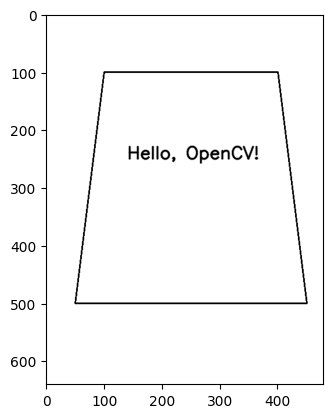

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 白い背景の画像を作成
width, height = 480, 640
img = np.ones((height, width, 3), dtype=np.uint8) * 255

# 台形の頂点を定義
pts = np.array([[100, 100], [400, 100], [450, 500], [50, 500]], np.int32)
pts = pts.reshape((-1, 1, 2))
# 台形を描画
cv2.polylines(img, [pts], isClosed=True, color=(0, 0, 0), thickness=2)

font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(img, 'Hello, OpenCV!', (140, 250), font, 1, (0, 0, 0), 2, cv2.LINE_AA)

# 円を描く
# cv2.circle(img, (250, 250), 100, (0, 0, 0), 1)

plt.imshow(img)
plt.show()

#### 前処理：台形の輪郭線を取り出す

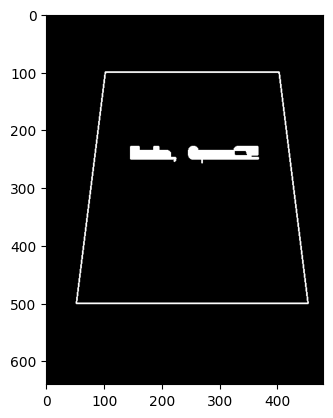

In [2]:
# 前処理：台形の輪郭線を取り出す

# グレースケール画像の取得
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 二値化
_, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)

# モルフォロジー変換：膨張と収縮を繰り返して線を抽出
kernel_length = max(1, img.shape[1] // 80)  # カーネルのサイズを画像の幅に基づいて決定
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 1))
morph = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

plt.imshow(morph, cmap="gray")
plt.show()

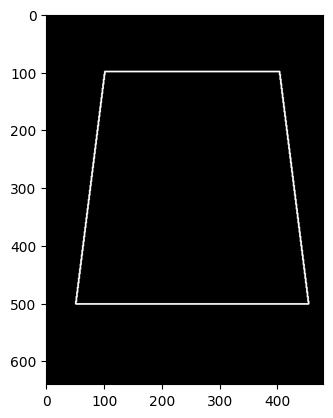

In [3]:
contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 輪郭を描画
contour_img = np.zeros_like(gray)
cv2.drawContours(contour_img, contours, -1, (255, 255, 255), 2)

plt.imshow(contour_img, cmap="gray")
plt.show()

#### 前処理：平滑化

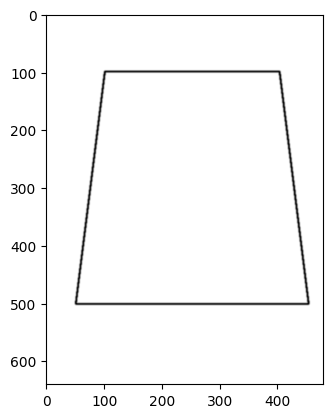

In [4]:
# 前処理2

# 白黒を反転
contour_img = 255 - contour_img

# 線がギザギザしているのでガウシアンブラーで平滑化
contour_img = cv2.GaussianBlur(contour_img, (5, 5), 0)

plt.imshow(contour_img, cmap="gray")
plt.show()

## Harrisによるコーナー検出

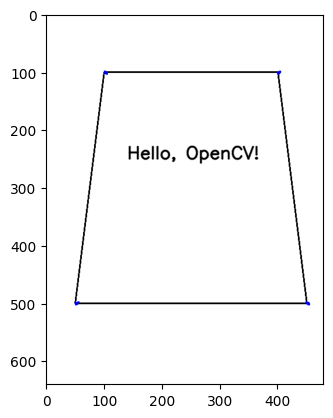

In [5]:
# Harris corner detection
dst = cv2.cornerHarris(np.float32(contour_img), blockSize=2, ksize=3, k=0.04)
# Dilate the result to mark the corners
dst = cv2.dilate(dst, None)
# Threshold for an optimal value, marking the corners in the original image
img_harris = img.copy()
img_harris[dst > 0.01 * dst.max()] = [0, 0, 255]

plt.imshow(img_harris)

### FASTによるコーナー検出

FASTは16x16ピクセルの範囲ごとにグレースケール画像の濃淡の領域を分割するように決定木を構築してコーナーを検出する手法

[OpenCV: FAST Algorithm for Corner Detection](https://docs.opencv.org/3.4/df/d0c/tutorial_py_fast.html)

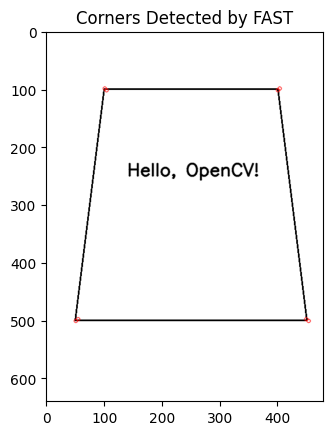

In [6]:
fast = cv2.FastFeatureDetector_create(threshold=100)
keypoints = fast.detect(contour_img, None)

# 検出されたコーナーを画像に描画
image_with_keypoints = cv2.drawKeypoints(img, keypoints, None, color=(255, 0, 0))

plt.imshow(image_with_keypoints)
plt.title("Corners Detected by FAST")
plt.show()

### 検出したコーナーたちを4点にまとめる

In [7]:
# コーナーの座標を取得
corners = cv2.KeyPoint_convert(keypoints)
corners

array([[101.,  99.],
       [403.,  99.],
       [104., 102.],
       [400., 102.],
       [ 55., 498.],
       [449., 498.],
       [ 51., 501.],
       [453., 501.]], dtype=float32)

In [8]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(corners)
centroids = kmeans.cluster_centers_
centroids

array([[401.5, 100.5],
       [ 53. , 499.5],
       [451. , 499.5],
       [102.5, 100.5]], dtype=float32)

In [9]:
values = centroids[:, 0] + centroids[:, 1]
idx = np.argsort(values)
centroids = centroids[idx]
centroids

array([[102.5, 100.5],
       [401.5, 100.5],
       [ 53. , 499.5],
       [451. , 499.5]], dtype=float32)

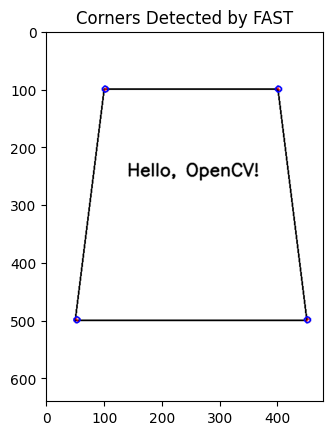

In [10]:
img_centroids = image_with_keypoints.copy()
for centroid in centroids:
    cv2.circle(img_centroids, tuple(centroid.astype("uint32")), radius=5, color=(0, 0, 255), thickness=2)

plt.imshow(img_centroids)
plt.title("Corners Detected by FAST")
plt.show()

## Perspective Transform

In [11]:
pts_src = centroids

In [14]:
# 変換後の座標（出力画像のサイズを決定）
# width, height = 300, 400  # 出力画像の幅と高さを指定
margin = 50  # 余白
pts_dst = np.array([
    [margin, margin],
    [width - margin - 1, margin],
    [margin, height - margin - 1],
    [width - margin - 1, height - margin - 1]
], dtype='float32')
pts_dst

array([[ 50.,  50.],
       [429.,  50.],
       [ 50., 589.],
       [429., 589.]], dtype=float32)

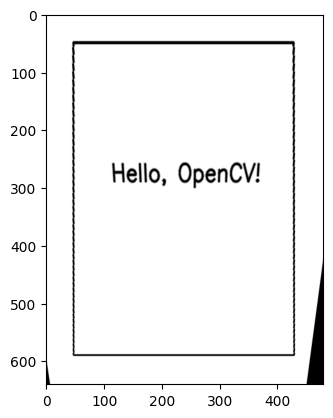

In [15]:
# 変換行列を計算
matrix = cv2.getPerspectiveTransform(pts_src, pts_dst)
# 変換を適用
transformed_img = cv2.warpPerspective(img, matrix, (width, height))

plt.imshow(transformed_img, cmap="gray")

## 参考

- [射影変換により画像から距離を推定する #Python - Qiita](https://qiita.com/ydclab_0003/items/1fc3d1468a39623bae60)
- [Skews and Perspectives with OpenCV - FreedomVC](https://www.freedomvc.com/index.php/2021/05/23/skews-and-perspectives/)
- [Python, OpenCVで幾何変換（アフィン変換・射影変換など） | note.nkmk.me](https://note.nkmk.me/python-opencv-warp-affine-perspective/)